In [33]:
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size)
        
        # definition of loss function: MSE is a good choice! 
        loss_func = torch.nn.MSELoss(reduction='none')
        
        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:
                
                # compute energies
                inputs, true_energies = train_data_batch
                pred_energies = self.model(inputs)
                
                # compute loss
                batch_loss = loss_func(pred_energies, true_energies)
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.mean().backward()
                self.optimizer.step()
                
                batch_importance = 1.0
                train_epoch_loss += batch_loss.mean().item() * batch_importance
            
            # use the self.evaluate to get loss on the validation set 
            val_epoch_loss = self.evaluate(val_data)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
        
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            # Plot train loss and validation loss
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validate')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")

        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        
        # init data loader
        data_loader = torch.utils.data.DataLoader(data, batch_size=self.batch_size)
        
        # init loss function
        loss_func = torch.nn.MSELoss(reduction='none')
        total_loss = 0.0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                
                # compute energies
                ts, true_energies = batch_data
                pred_energies = self.model(ts)
                
                # compute loss
                batch_loss = loss_func(pred_energies, true_energies)

                batch_importance = 1.0
                total_loss += batch_loss.mean().item() * batch_importance
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Report the mean absolute error
            # The unit of energies in the dataset is hartree
            # please convert it to kcal/mol when reporting the mean absolute error
            # 1 hartree = 627.5094738898777 kcal/mol
            # MAE = mean(|true - pred|)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return total_loss
        

SimpleModel - Number of parameters: 769
Initialize training data...


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 39.77it/s]

Training/evaluation complete


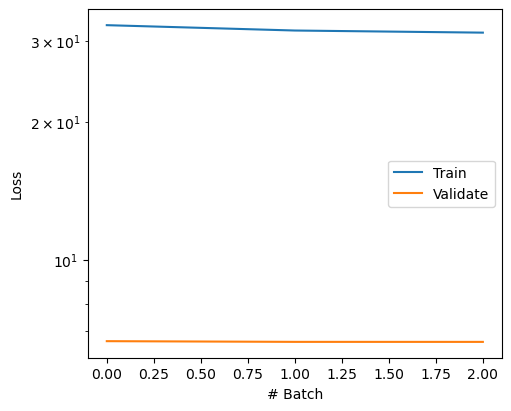

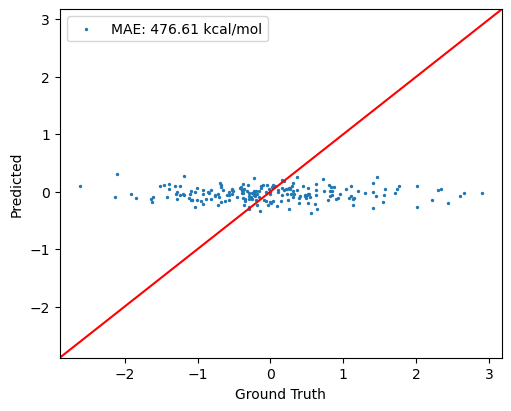

In [35]:
#testing the code
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class SimpleModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.layers(x)
        
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self, size=1000):
        self.inputs = torch.randn(size, 10)
        self.outputs = torch.randn(size, 1)
        
    def __len__(self):
        return len(self.inputs)
                
    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]
        
model = SimpleModel()
train_dataset = DummyDataset(1000)
val_dataset = DummyDataset(200)
trainer = ANITrainer(model, batch_size=32, learning_rate=0.001, epoch=3, l2=0.01)
train_losses, val_losses = trainer.train(train_dataset, val_dataset)
test_loss = trainer.evaluate(val_dataset, draw_plot=True)
print("Training/evaluation complete")